In [401]:
%reset -f
import time
import numpy as np
import sympy as sp
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.interpolate as interpolate
from scipy.integrate import solve_bvp

# from tueplots.bundles import probnum2025
# plt.rcParams.update(probnum2025())


Changes with respect to the previous version: exclusion of the constant term by rewriting the equation as:
\begin{equation}
    \nabla^2 (\psi + C) = \nabla^2 \psi = \frac{S_1}{\psi + C}
\end{equation}
Since we are iteratively solving this equation, we can model this as:
\begin{equation}
    \nabla^2 (\psi^{(n+1)} + C) = \nabla^2 \psi^{(n+1)} = \frac{S_1}{\psi^{(n)} + C}
\end{equation}
in which $C$ is selected such that it satisfies the boundary conditions at $r = R$


## 0. Solutions to the TOV-Equations and Source/Matter Terms

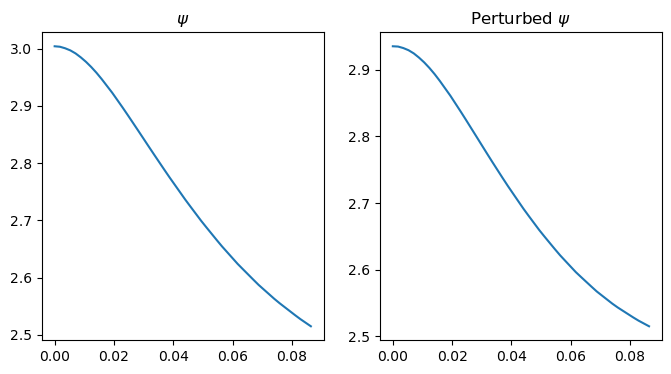

In [402]:
# Load the variables from tov-final
r_o   = 1.0e+3          # outer radius (maximum radius)
r_c   = 1.0e-1          # central radius (minimum radius)
P_c   = 1.0e-1          # central pressure (maximal pressure)

# Specify and load the file
filename    = f'../../data/tov_{round(np.log10(r_o)):+}{round(np.log10(r_c)):+}{round(np.log10(P_c)):+}.npy'
filename    = f'../../data/tov_112.npy'
loaded_data = np.load(filename)

# Unpack the values
r, m, P, rho, R, alpha, psi = loaded_data

# Interpolate all the data (in oversampled form) to allow for a linear grid
m_intp     = interpolate.interp1d(R, m,     kind='linear', bounds_error=False)
P_intp     = interpolate.interp1d(R, P,     kind='linear', bounds_error=False)
rho_intp   = interpolate.interp1d(R, rho,   kind='linear', bounds_error=False)
alpha_intp = interpolate.interp1d(R, alpha, kind='linear', bounds_error=False)
psi_intp   = interpolate.interp1d(R, psi,   kind='linear', bounds_error=False)

# Convert to linear grid
nb_points = 50
R = np.linspace(np.min(R), np.max(R), nb_points)

m      = m_intp(R)
P      = P_intp(R)
rho    = rho_intp(R)
alpha  = alpha_intp(R)
psi    = psi_intp(R)

# A large perturbation can be used as an initialization of psi
# Perturbation parameters
center_value  = 0.3        # Center value
sigma         = 1.0e-1     # Width of the full Gaussian
amplitude     = 1.0e-1      # Scale factor

# Construction of the perturbation
center_index  = np.argmin(np.abs(R - center_value))
R_centered    = (R - R[center_index])/R[center_index]
gaussian      = amplitude * np.exp(-((R - R[center_index]) ** 2) / (2 * sigma**2))
psi_perturbation = gaussian * R_centered

# Define the perturbed density
perturbed_psi = psi + psi_perturbation

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(R, psi)
ax[0].set_title(r"$\psi$")
ax[1].plot(R, perturbed_psi)
ax[1].set_title(r"Perturbed $\psi$");

## 1. Problem Definition

Given the perturbation on the density, the vector equations are trivially zero.

We focus immediately on the nonlinear ODE:
\begin{equation}
\nabla^{2} \psi = \frac{S_{1}}{\psi} + \frac{S_{7}}{\psi^7}
\end{equation}
which we will solve in an iterative fashion as we will compute $\psi_{(n+1)}$ in iteration $n+1$ based on the previous estimate $\psi_{(n)}$ in iteration $n$:
\begin{equation}
\nabla^{2} \psi_{(n+1)} = \frac{S_{1}}{\psi_{(n)}} + \frac{S_{7}}{\psi_{(n)}^7}
\end{equation}
Assume we have an initial guess $\psi_{(0)}$, we aim to find $\psi$ density $\rho$. This leads to the source terms:
\begin{align}
    S_1   &= -2 \pi \rho \psi_{(n)}^6 \\ 
    S_7   &= 0 \\
\end{align}
such that the nonlinear ODE now reads:
\begin{equation}
\nabla^{2} \psi_{(n+1)} = \frac{S_{1}}{\psi_{(n)}}
\end{equation}
In spherical symmetry, this ODE results in:
\begin{equation}
    \big( \partial_{r}^{2} + \frac{2}{r} \partial_r \big) \psi_{(n+1)} = \frac{S_{1}}{\psi_{(n)}}
\end{equation}
It should satisfy the following boundary conditions:
\begin{align}
    \frac{d\psi}{dr}(0) &= 0 \\
    \psi(R) &= 1 + \frac{C}{2R_{max}} 
\end{align}
For the uncertaint quantification part, see the shared notes.

## 2. Solver with Uncertainty Quantification

In [403]:
# Definition of the source term S1
S1 = - 2*np.pi*rho*psi**6

# Symbol nomenclature
r     = sp.symbols('r')
n     = sp.symbols('n')
R_max = sp.symbols('R_max')

# Definition of the basis functions
basis_func = sp.sqrt(2) * sp.sin(n * sp.pi * r / R_max) / (r * n**2)

# Definition of the laplacian operator
laplacian = lambda r, func: sp.diff(func, r, 2) + 2 / r * sp.diff(func, r)



00%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2819.43it/s]

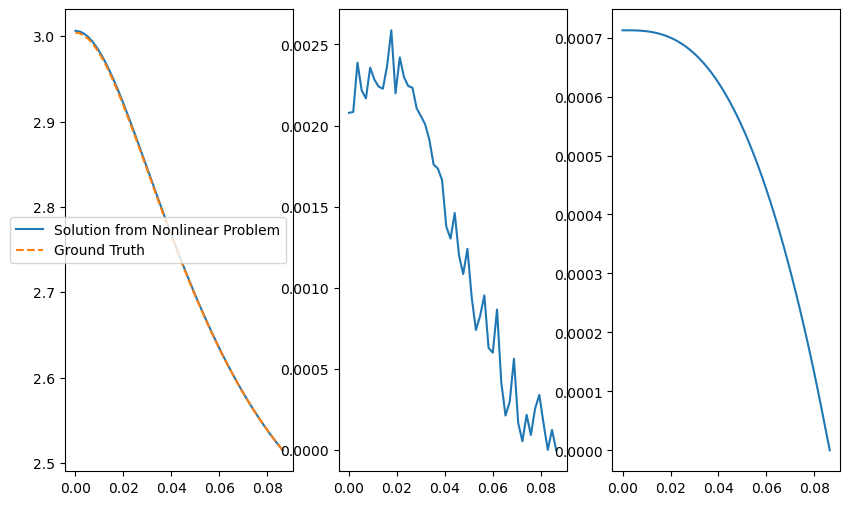

In [424]:
# ==================================================================
# Function definitions
# ================================================================== 

# 1a. Construction of the source term
def construct_source_term(psi):
    return S1 / psi

# 1b. Construction of the design matrix
def construct_design_matrix(R, N, basis_func, laplacian):
    
    # Lambdify the functions
    basis_func_lambd = sp.lambdify((r, n, R_max), basis_func)
    laplacian_lambd  = sp.lambdify((r, n, R_max), sp.simplify(laplacian(r, basis_func)))

    # Matrix initialization
    basis_func_matrix = np.zeros((len(R), N))
    design_matrix     = np.zeros((len(R), N))

    # Construction of the basis function and design matrix
    # Avoid i = 0, as that result in the zero-function
    for i in range(1, N+1):
        # Regular ODE solution
        basis_func_matrix[:, i-1] = basis_func_lambd(R, i, max(R))
        design_matrix[:, i-1]     = laplacian_lambd(R, i, max(R))

    return basis_func_matrix, design_matrix

# 2. ODE solver
def solve_ode(basis_func_matrix, design_matrix, observations, prior_mean, prior_prec, likelihood_prec):
    
    # Weight vector: posterior distribution on the weights
    b = design_matrix.T @ likelihood_prec @ observations + np.squeeze(prior_prec @ prior_mean)
    w_posterior_prec_matrix = design_matrix.T @ likelihood_prec @ design_matrix + prior_prec
    w_posterior_mean = np.linalg.solve(w_posterior_prec_matrix, b)

    # Source function: posterior mean and covariance
    source_func_mean = np.squeeze(design_matrix @ w_posterior_mean)
    source_func_covariance_matrix = design_matrix @ np.linalg.solve(w_posterior_prec_matrix, design_matrix.T)
    
    # ODE solution: posterior mean and covariance
    solution_mean = np.squeeze(basis_func_matrix @ w_posterior_mean)
    solution_covariance_matrix = basis_func_matrix @ np.linalg.solve(w_posterior_prec_matrix, basis_func_matrix.T)

    return solution_mean, solution_covariance_matrix, source_func_mean, source_func_covariance_matrix, w_posterior_mean, w_posterior_prec_matrix


# ==================================================================
# Solving the ODE
# ================================================================== 
# Initialization and solver definitions
psi_init                       = perturbed_psi 
iteration_steps                = 100
N                              = 10                 # Number of basis functions
s                              = 10**(4)            # Likelihood variance on S1 in the source term
l                              = 10**(12)           # Prior variance on psi, i.e. the solution

# Conversion to (co-)variance matrices
S                              = s*np.identity(len(R))     
L                              = l*np.identity(N)          

# Definition and initialization of arrays to store evolution of variables
psi_mean_storage               = np.zeros((len(psi), iteration_steps+1))
psi_var_storage                = np.zeros((len(psi), len(psi), iteration_steps+1))
w_mean_storage                 = np.zeros((N, iteration_steps+1))
w_prec_storage                 = np.zeros((N, N, iteration_steps+1))
likelihood_prec_storage        = np.zeros((len(psi), len(psi), iteration_steps+1))
source_term_storage            = np.zeros((len(psi), iteration_steps+1))

psi_mean_storage[:,0]          = psi_init
psi_var_storage[:,:,0]         = np.identity(len(psi))
w_mean_storage[:,0]            = np.squeeze(np.zeros((N, 1)))
w_prec_storage[:,:,0]          = np.linalg.inv(L)
likelihood_prec_storage[:,:,0] = np.linalg.inv(S)
source_term_storage[:,0]       = construct_source_term(psi_init)

# Define the basis function and design matrix, and boundary value at R = R_max
basis_func_matrix, design_matrix   = construct_design_matrix(R, N, basis_func, laplacian)
boundary_value                     = psi[-1] 

# Iterative refinement of the ODE solution
for i in tqdm(range(iteration_steps)):
    
    # Call the ODE solver
    solution_mean_primal, solution_variance_primal, _, _, w, w_prec = solve_ode(basis_func_matrix, design_matrix, source_term_storage[:,i], \
                                                                                w_mean_storage[:,i], w_prec_storage[:,:,i], likelihood_prec_storage[:,:,i])

    # Define the Jacobians required for the Gaussian approximation of the likelihood
    Jf_psi = np.diag(-S1/(solution_mean_primal + boundary_value)**2)                                       
    Jf_S   = np.diag(1/(solution_mean_primal + boundary_value))

    # As S1 vanishes at R_max, a small numerical stabilizer is added to preserve the full-rankness of the resulting precision matrix
    Jf_psi[-1, -1] = 1           
    
    # Gaussian approximation of the likelihood precision (TODO: Update this line)
    likelihood_prec = np.linalg.inv(Jf_S @ S @ Jf_S.T + Jf_psi @ np.linalg.inv(psi_var_storage[:,:,i]) @ Jf_psi.T)
    
    # Store intermediate results
    psi_mean_storage[:, i+1]         = solution_mean_primal
    psi_var_storage[:,:,i+1]         = solution_variance_primal
    w_mean_storage[:,i+1]            = w
    w_prec_storage[:,:,i+1]          = w_prec
    likelihood_prec_storage[:,:,i+1] = likelihood_prec
    source_term_storage[:,i+1]       = construct_source_term(solution_mean_primal + boundary_value)

    
# ==================================================================
# Visualization of the solution
# ================================================================== 
fig, ax = plt.subplots(1,3, figsize=(10,6))

# Ground truth vs. Solution including standard deviation
solution_std = np.sqrt(np.diag(solution_variance_primal))
ax[0].plot(R, (solution_mean_primal + boundary_value), label="Solution from Nonlinear Problem")
ax[0].fill_between(R, solution_mean_primal + boundary_value - solution_std, solution_mean_primal + boundary_value + solution_std, alpha=0.15)
ax[0].plot(R, psi, ls='--', label="Ground Truth")
ax[0].legend()

# Absolute error
ax[1].plot(R, np.abs(solution_mean_primal + boundary_value - psi))

# Standard deviation
ax[2].plot(R, solution_std);

## Solver without Uncertainty Propagation


00%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 2016.88it/s]

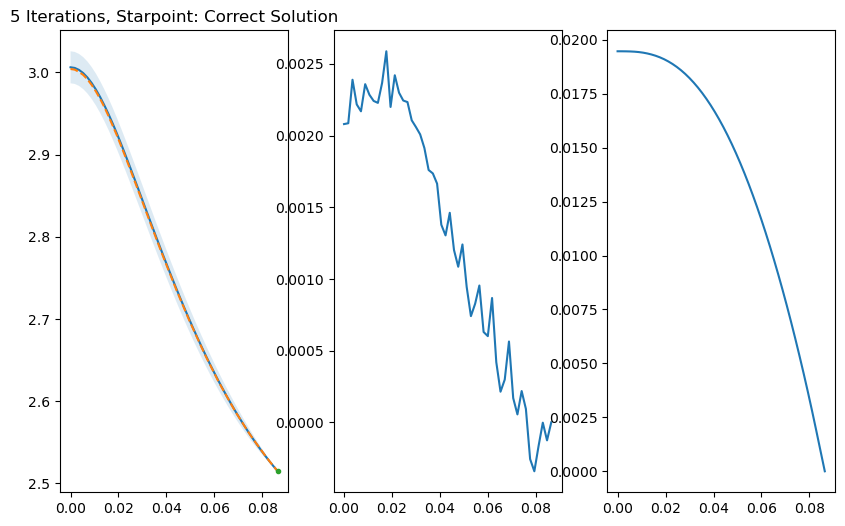

In [405]:
# Function definitions
# 1a. Construction of the source term
def construct_source_term(psi):
    return S1 / psi

# 1b. Construction of the design matrix
def construct_design_matrix(R, N, basis_func, laplacian):
    
    # Lambdify the functions
    basis_func_lambd = sp.lambdify((r, n, R_max), basis_func)
    laplacian_lambd = sp.lambdify((r, n, R_max), sp.simplify(laplacian(r, basis_func)))

    # Matrix initialization
    basis_func_matrix = np.zeros((len(R), N))
    design_matrix = np.zeros((len(R), N))

    # Construction of the basis function and design matrix
    # Avoid i equal to one as that introduces problems with the sinc function
    for i in range(1, N+1):
        # Regular ODE solution
        basis_func_matrix[:, i-1] = basis_func_lambd(R, i, max(R))
        design_matrix[:,  i-1] = laplacian_lambd(R, i, max(R))

    return basis_func_matrix, design_matrix

# 2. ODE solver
def solve_ode(basis_func_matrix, design_matrix, observations, likelihood_precision, prior_precision, prior_mean):
    
    # Reformulate the problem into an A @ w = b problem, and solve the least-squares (in the "classical perspective")
    w_precision_matrix = design_matrix.T @ likelihood_precision @ design_matrix + prior_precision
    b = np.expand_dims(design_matrix.T @ likelihood_precision @ observations, axis=1)

    # Solve the system
    w_mu = np.linalg.solve(w_precision_matrix, b)

    # Computation of the source function mean
    source_func_mean_primal = design_matrix @ w_mu
    source_func_mean_primal = np.squeeze(source_func_mean_primal)
    
    # Computation of the source function variance
    v = np.linalg.solve(w_precision_matrix, design_matrix[:-1,:].T)
    source_func_variance_primal = design_matrix @ v
    
    # Computation of the solution mean
    solution_mean_primal = basis_func_matrix @ w_mu
    solution_mean_primal = np.squeeze(solution_mean_primal)
    
    # Computation of the solution variance
    v = np.linalg.solve(w_precision_matrix, basis_func_matrix.T)
    solution_variance_primal = basis_func_matrix @ v

    return solution_mean_primal, solution_variance_primal, source_func_mean_primal, source_func_variance_primal, w_mu, w_precision_matrix
    

psi_init = perturbed_psi 
N = 10                               # Number of basis functions
S = 1.0e4*np.identity(len(R))     # Sigma matrix
L = 1.0e6*np.identity(N)             # 

# Define the arrays which store the variables
iteration_steps        = 5
psi_mean_storage       = np.zeros((len(psi), iteration_steps+1))
psi_var_storage        = np.zeros((len(psi), len(psi), iteration_steps+1))

# Initialization
psi_mean_storage[:, 0] = psi_init

# Boundary condition value
y_BC2 = psi[-1] 

basis_func_matrix, design_matrix = construct_design_matrix(R, N, basis_func, laplacian)
source_term = construct_source_term(psi_init)

for i in tqdm(range(1, iteration_steps + 1)):
    
    # Solve the ODE
    solution_mean_primal, solution_variance_primal, _, _, A, w = solve_ode(basis_func_matrix, design_matrix, source_term, np.linalg.inv(S), np.linalg.inv(L), np.zeros((N, 1)))
    
    # Storage
    psi_mean_storage[:, i] = solution_mean_primal
    psi_var_storage[:,:,i] = solution_variance_primal

    # Construct the new source term
    source_term = construct_source_term(solution_mean_primal + y_BC2)

fig, ax = plt.subplots(1,3, figsize=(10,6))

ax[0].plot(R, solution_mean_primal + y_BC2, label="Solution from Nonlinear Problem")
solution_std = np.sqrt(np.diag(solution_variance_primal))
ax[0].fill_between(R, solution_mean_primal + y_BC2 - solution_std, solution_mean_primal + y_BC2 + solution_std, alpha=0.15)
ax[0].plot(R, psi, ls='--', label="Ground Truth")
ax[0].plot(np.max(R), y_BC2, marker='.', ls='none', label="Initial Condition")
ax[0].set_title("5 Iterations, Starpoint: Correct Solution")


ax[1].plot(R, solution_mean_primal + y_BC2 - psi)

ax[2].plot(R, solution_std);